# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np
import pandas as pd

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

32.651547912714257

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.863400553931569

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
x = np.random.exponential(size = sample_size)

In [7]:
e = np.random.uniform(-1, 1, size = sample_size)

In [8]:
y = f(x) + e

In [17]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
linspace = linspace.reshape(-1, 1)

In [9]:
from sklearn import tree
treg = tree.DecisionTreeRegressor()

In [18]:
treg.fit(x, y)
pred1 = treg.predict(linspace)

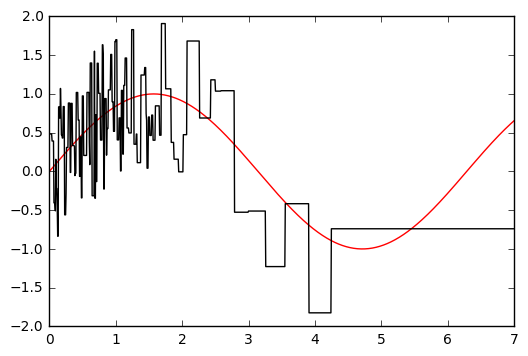

In [21]:
plt.plot(linspace, f(linspace), color='red')
plt.plot(linspace, pred1, color='black')

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

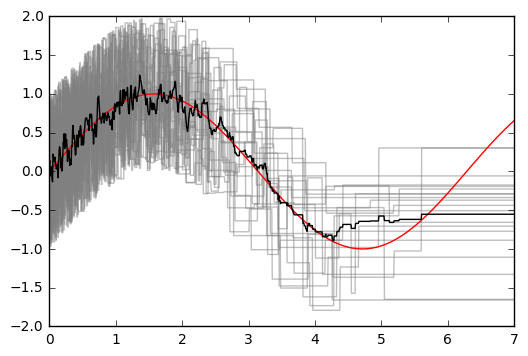

In [27]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    treg = tree.DecisionTreeRegressor()
    treg.fit(x, y)
    pred = treg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

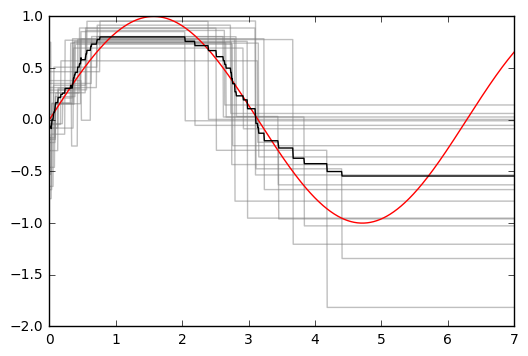

In [28]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    treg = tree.DecisionTreeRegressor(max_depth=2)
    treg.fit(x, y)
    pred = treg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

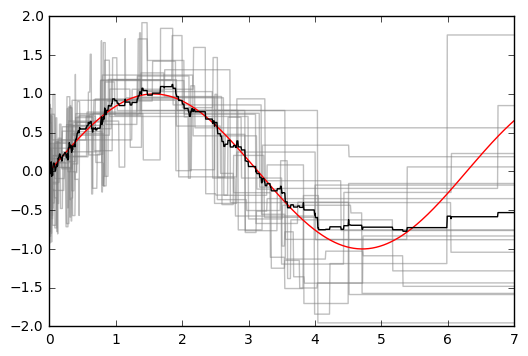

In [29]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    treg = tree.DecisionTreeRegressor(max_depth=4)
    treg.fit(x, y)
    pred = treg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Как видно из графиков решающих деревьев с глубиной 2 и 4, чем больше глубина - тем меньше смещение. Но при этом за это приходится платить разбросом. Далее стоит отметить тот факт, что при автоподборе величины глубины дерева (первый график) смещения фактически нет (на глаз, увы, сложно сказать, есть ли оно вовсе), но наблюдается наибольший разброс среди 3-х графиков. Происходит это ввиду того, что модель строится с автоматическим подбором гиперпараметра max_depth (пока в одном листе не окажутся объекты из одного класса или в нем не окажется количество объектов соответствующее нижней допустимой границе). Таким образом, можно сделать вывод, что в первой модели (с автопободром гиперпараметра) он значительно больше 4-ех.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

#### LinearReg

In [30]:
from sklearn.linear_model import LinearRegression

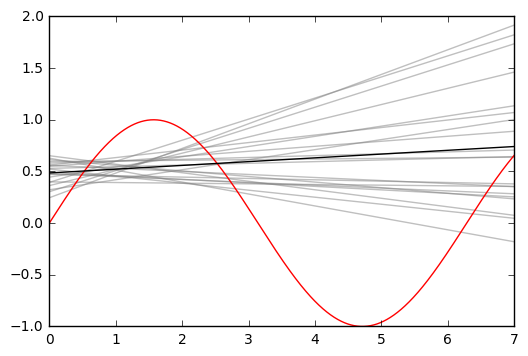

In [31]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(x, y)
    pred = reg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

Здесь результаты довольно предсказуемы и очевидны. Как видно на графике выше, линейная регрессия способна восстанавливать только линейные (не может быть!) зависимости. По этой причине имеет место как большой разброс, так и приличное смещение.

#### SVM

In [32]:
from sklearn import svm

C:\Users\Vlad\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


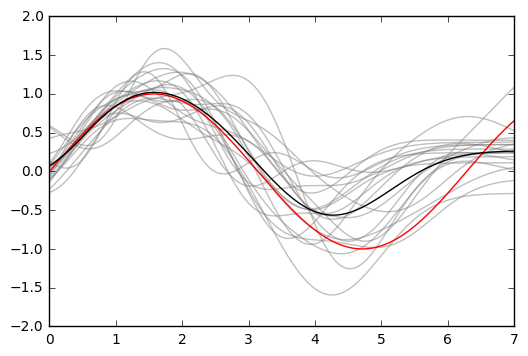

In [33]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = svm.SVR(kernel = 'rbf', gamma = 1)
    reg.fit(x, y)
    pred = reg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

C:\Users\Vlad\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


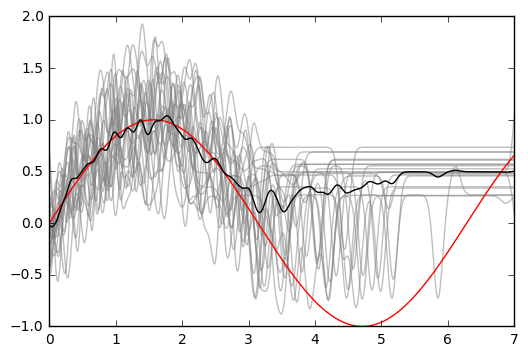

In [34]:
y_mean_pr = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    e = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + e
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = svm.SVR(kernel = 'rbf', gamma = 100)
    reg.fit(x, y)
    pred = reg.predict(linspace)
    y_mean_pr += pred
    plt.plot(linspace, pred, color='gray', alpha=0.5)
plt.plot(linspace, f(linspace), color='red')
y_pred_mean = (y_mean_pr/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color='black')

Здесь по сравнению с линейной регрессией результаты интересней. Во-первых, можно можно сделать вывод,что при больших значениях параметра $\gamma$, в том числе равном $100$, наблюдается явное переобучение. Этим объясняется также и наличие огромного разброса, начинающегося с определенных значений икса (тем не менее, смещение здесь, как видно, не особо критичное). Во-вторых, малое значение того же гиперпараметра обеспечивает не только близкое к нулевому смещение, но и малый разброс (при малых иксах зависимость очень близка к реальной), что говорит о высокой предикативной способности нашей модели.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [163]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tic_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

### Mushrooms

In [117]:
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Как видим, все признаки являются категориальными. С помощью LabelEncoder'a, согласно заданию, преобразуем все категориальные в вещественные и, соответственно, с помощью get_dummies() все вещественные в категориальные (здесь не совсем релевантно ввиду того, что все признаки априори категориальные, но тем не менее...)

In [118]:
y_mush = mushrooms[0]
X_mush = mushrooms.drop(0, axis = 1)

In [119]:
X_mush_dummies = pd.get_dummies(X_mush)

In [120]:
laben = LabelEncoder()

In [121]:
y_mush_le = laben.fit_transform(y_mush)
for i in range(1, 1 + len(X_mush.columns)):
    X_mush[i] = laben.fit_transform(X_mush[i])

In [122]:
X_mush.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


#### Кросс-валидация

In [123]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [124]:
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=13)
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_mush, y = y_mush_le, cv = cv).mean()

1.0

In [125]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_mush_dummies, y = y_mush, cv = cv).mean()

1.0

### Tic-rac-Toe

In [126]:
tic_toe.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Здесь, как мы видим, задача не отличается от предыдущей. Проделаем те же шаги.

In [127]:
y_tic = tic_toe[9]
X_tic = tic_toe.drop(9, axis = 1)

In [128]:
X_tic_dummies = pd.get_dummies(X_tic)

In [143]:
y_tic_le = laben.fit_transform(y_tic)
for i in range(len(X_tic.columns)):
    X_tic[i] = laben.fit_transform(X_tic[i])

#### Кросс-валидация

In [144]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_tic, y = y_tic, cv = cv).mean()

0.88333333333333319

In [131]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_tic_dummies, y = y_tic, cv = cv).mean()

0.93645833333333339

### Cars

In [132]:
cars.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Как мы видим особенность нашего датафрейма предполагает, что наилучшим способом предобработки информации - ручное перекодирование. Тем не менее ввиду необходимости задания воспользуемся теми же функциями, чтобы создать все вещественные и все категориальные признаки в отдельных датафреймах.

In [133]:
y_cars = cars[6]
X_cars = cars.drop(6, axis=1)

In [135]:
for i in range(len(y_cars)):
    if y_cars[i] == 'unacc':
        y_cars[i] = 0
    elif y_cars[i] == 'acc':
        y_cars[i] = 0
    elif y_cars[i] == 'good':
        y_cars[i] = 1
    elif y_cars[i] == 'vgood':
        y_cars[i] = 1

In [136]:
X_cars_best = X_cars.copy() # не знал, что если написать просто X_cars_best = X_cars, то изменение одного 
                            # датафрейма сразу меняет другой :'('
X_cars_best[X_cars_best == 'low'] = 0
X_cars_best[X_cars_best == 'small'] = 0
X_cars_best[X_cars_best == 'med'] = 1
X_cars_best[X_cars_best == 'high'] = 2
X_cars_best[X_cars_best == 'big'] = 2
X_cars_best[X_cars_best == 'vhigh'] = 3
X_cars_best[X_cars_best == 'more'] = 4
X_cars_best[X_cars_best == '5more'] = 5

In [137]:
X_cars_best.head()

,0,1,2,3,4,5
0,3,3,2,2,0,0
1,3,3,2,2,0,1
2,3,3,2,2,0,2
3,3,3,2,2,1,0
4,3,3,2,2,1,1


In [138]:
X_cars_dummies = pd.get_dummies(X_cars)

In [139]:
X_cars.head()

,0,1,2,3,4,5
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [145]:
for i in range(len(X_cars.columns)):
    X_cars[i] = laben.fit_transform(X_cars[i])

#### Кросс-валидация

In [147]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_cars, dtype='int'), y = np.array(y_cars, dtype='int'), cv = cv).mean()

0.98420038535645471

In [148]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_cars_dummies, dtype='int'), y = np.array(y_cars, dtype='int'), cv = cv).mean()

0.97957610789980731

In [ ]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_tic, y = y_tic_le, cv = cv).mean()

In [149]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_cars_best, dtype='int'), y = np.array(y_cars, dtype='int'), cv = cv).mean()

0.98554913294797686

### Nursery

In [165]:
nursery.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


Как видим, здесь ситуация аналогична той, что была ранее. Проделаем те же шаги, но прежде из описания данных вытащим уникальные значения в каждом из признаков.

- parents: usual, pretentious, great_pret
- has_nurs: proper, less_proper, improper, critical, very_crit
- form: complete, completed, incomplete, foster
- children: 1, 2, 3, more
- housing: convenient, less_conv, critical
- finance: convenient, inconv
- social: non-prob, slightly_prob, problematic
- health: recommended, priority, not_recom

In [166]:
y_nur = nursery[8]
X_nur = nursery.drop(8, 1)

In [167]:
for i in range(len(y_nur)):
    if y_nur[i] == 'not_recom':
        y_nur[i] = 0
    elif y_nur[i] == 'recommend':
        y_nur[i] = 0
    elif y_nur[i] == 'very_recom':
        y_nur[i] = 1
    elif y_nur[i] == 'priority':
        y_nur[i] = 1
    elif y_nur[i] == 'spec_prior':
        y_nur[i] = 1

In [168]:
X_nur_best = X_nur.copy()
X_nur_best[0][X_nur_best[0] == 'usual'] = 0
X_nur_best[0][X_nur_best[0] == 'pretentious'] = 1
X_nur_best[0][X_nur_best[0] == 'great_pret'] = 2
X_nur_best[1][X_nur_best[1] == 'proper'] = 4
X_nur_best[1][X_nur_best[1] == 'less_proper'] = 3
X_nur_best[1][X_nur_best[1] == 'improper'] = 2
X_nur_best[1][X_nur_best[1] == 'critical'] = 1
X_nur_best[1][X_nur_best[1] == 'very_crit'] = 0
X_nur_best[2][X_nur_best[2] == 'complete'] = 0
X_nur_best[2][X_nur_best[2] == 'completed'] = 1
X_nur_best[2][X_nur_best[2] == 'incomplete'] = 2
X_nur_best[2][X_nur_best[2] == 'foster'] = 3
X_nur_best[3][X_nur_best[3] == '1'] = 1
X_nur_best[3][X_nur_best[3] == '2'] = 2
X_nur_best[3][X_nur_best[3] == '3'] = 3
X_nur_best[3][X_nur_best[3] == 'more'] = 0
X_nur_best[4][X_nur_best[4] == 'convenient'] = 2
X_nur_best[4][X_nur_best[4] == 'less_conv'] = 1
X_nur_best[4][X_nur_best[4] == 'critical'] = 0
X_nur_best[5][X_nur_best[5] == 'convenient'] = 1 
X_nur_best[5][X_nur_best[5] == 'inconv'] = 0
X_nur_best[6][X_nur_best[6] == 'nonprob'] = 2 
X_nur_best[6][X_nur_best[6] == 'slightly_prob'] = 1
X_nur_best[6][X_nur_best[6] == 'problematic'] = 0
X_nur_best[7][X_nur_best[7] == 'recommended'] = 2
X_nur_best[7][X_nur_best[7] == 'priority'] = 1
X_nur_best[7][X_nur_best[7] == 'not_recom'] = 0

In [169]:
X_nur_dummies = pd.get_dummies(X_nur)

In [170]:
for i in range(len(X_nur.columns)):
    X_nur[i] = laben.fit_transform(X_nur[i])

#### Кросс-валидация

In [171]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_nur, dtype='int'), y = np.array(y_nur, dtype='int'), cv = cv).mean()

0.99963991769547322

In [172]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_nur_dummies, dtype='int'), y = np.array(y_nur, dtype='int'), cv = cv).mean()

0.99966563786008233

In [173]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=np.array(X_nur_best, dtype='int'), y = np.array(y_nur, dtype='int'), cv = cv).mean()

0.99976851851851856

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улучшить работу алгоритмов?

### Mushrooms

В обоих случаях точность составила единицу. Здесь можно сделать вывод лишь о том, что особенность предоставленных данных позволяет использовать любую из кодировок, поскольку это приведет к одному и тому же результату (или их разница будет бесконечно мала). Тем не менее, дамми-данные должны давать лучший результат среди этих двух, но, как говорится, как уж есть :)

### Tic-Rac-Toe

Здесь уже разница не прость есть, а она существенна. Напомним, что данные аналогичны тем, что были проанализированы ранее, однако, опять-таки перевод признаков в категориальные значительно увеличил значение качества модели. Это вполне логично, поскольку признаки в датафрейме всецело категориальные.

### Cars

В данном случае результаты отличны от первых двух. Во-первых, дамми-данные теперь дают худший результат среди всех. Это можно объяснить тем, что данные предполагают дамми-преобразование не ко всем признакам, а только к некоторым. Во-вторых, как и следовало ожидать, наилучший результат был достигнут на данных, созданных "вручную", где овеществление произошло на основе уникальных значений всех признаков. 

### Nursery

Наконец, применительно к последним данным мы можем сказать следующие факты. Результаты дамми-преобразований и овеществления через лейблинг дали фактически одинаковые результаты, отличающиеся на стотысячные(!). Самое примечательное здесь - что, как и в прошлом датафрейме, лучший результат соответствует датафрейму созданному на основе лейблинга вручную, что само собой логично и предсказуемо.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [175]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [176]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [177]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [179]:
X_wine = wine.drop('quality', axis=1)
y_wine = wine['quality']

In [183]:
cv = ShuffleSplit(n_splits= 3, test_size=0.3, random_state = 13)

In [186]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), 
                X=X_wine, y = y_wine, cv = cv).mean()

0.59444444444444444

In [185]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score), 
                X=X_wine, y = y_wine, cv = cv).mean()

0.66805555555555551

In [187]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), scoring = make_scorer(accuracy_score), 
                X=X_wine, y = y_wine, cv = cv).mean()

0.67708333333333337

In [188]:
cross_val_score(estimator = RandomForestClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score), 
                X=X_wine, y = y_wine, cv = cv).mean()

0.68611111111111123

Действительно качество улучшается с каждой моделью!

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

Для начала перемешаем объекты

In [189]:
from sklearn.utils import shuffle

In [191]:
X_wine, y_wine = shuffle(X_wine, y_wine, random_state = 13)

Теперь резделим выборку в пропорции 7/3 на трэйн и на тест (классека)

In [192]:
from sklearn.model_selection import train_test_split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size = 0.3, random_state = 13)

Пора перебирать

In [193]:
rndf = RandomForestClassifier(n_estimators = 100,  warm_start = True, random_state = 13)

In [205]:
max(acc_score)

1.0

In [202]:
acc_score = []
n_est = np.arange(100, 5100, 100)
for i in range(len(n_est)):
    rndf.fit(X_train, y_train)
    y_pred = rndf.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))
    rndf.set_params(n_estimators = n_est[i])

C:\Users\Vlad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\Users\Vlad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


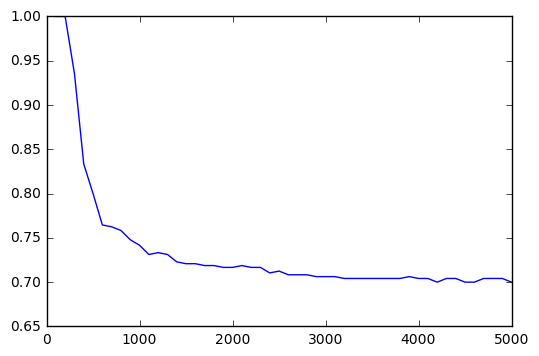

In [203]:
plt.plot(n_est, acc_score)

Как мы видим, при больших значениях количества деревьев, т.е. параметра n_esimators присутствует явное переобучение, поскольку метрика качества уменьшается. Что примечательно, существует количество деревьев, при котором качество модели наивысшее! К слову, это довольно редко происходит, но, увы, ошибки у себя в моделировании не вижу :(
Итак, переобучение имеет место с определенного значения параметра n_est.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [207]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

Здесь, увы, без помощи мастеров-программистов с Гитхаба не обойтись. Были использованы следующие ресурсы:

https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

In [208]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils

Код ниже нагло взят из гитхабовской работы, но я каюсь!

In [320]:
X_train = x_train.reshape(60000, 784)
X_test = x_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [227]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [228]:
model.fit(x=X_train, y=Y_train, batch_size=128, nb_epoch = 5, verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 15s - loss: 0.3375 - acc: 0.9043 - val_loss: 0.1878 - val_acc: 0.9464
Epoch 2/5
60000/60000 [==============================] - 15s - loss: 0.1577 - acc: 0.9538 - val_loss: 0.1321 - val_acc: 0.9604
Epoch 3/5
60000/60000 [==============================] - 15s - loss: 0.1178 - acc: 0.9656 - val_loss: 0.1112 - val_acc: 0.9674
Epoch 4/5
60000/60000 [==============================] - 14s - loss: 0.0932 - acc: 0.9724 - val_loss: 0.0975 - val_acc: 0.9706
Epoch 5/5
60000/60000 [==============================] - 15s - loss: 0.0778 - acc: 0.9769 - val_loss: 0.0919 - val_acc: 0.9717


Итак, как видно выше, наибольшая точность при 5 эпохах на тестовой выборке равна 0.9717, что довольно хорошо!

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [240]:
from keras.layers import Conv2D, MaxPooling2D

Для начала стоит сказать, что вылезала долго проблема размерности наших данных и необходимых аргументов в сверточных слоях. Поэтому был использован код из второй ссылки, где немного изменятся размерность наших картинок.

In [351]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

In [352]:
input_shape

(28, 28, 1)

In [349]:
model = Sequential()

model.add(Conv2D(32, nb_row=3, nb_col=3, activation='relu', input_shape=input_shape))
model.add(Conv2D(64, nb_row=3, nb_col=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

К сожалению, целый день прогонял и так и не подобрал слои и их параметры... :(

In [353]:
model.fit(x=X_train, y=Y_train, batch_size=128, nb_epoch = 5, verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 6272/60000 [==>...........................] - ETA: 311s - loss: 2.3026 - acc: 0.0990

KeyboardInterrupt: 

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 